# 1.数据预处理

In [2]:
import pandas as pd

#@ 对Excel文件的content内容进行预处理,并输出为文本文件
def excel_to_txt(df:pd.DataFrame,txt_name:str):
    """
    * df : 需要转化为txt的DataFrame对象
    * txt_name : 转化完成后的输出路径(后缀为.txt)
    """

    #! 去除空格
    df['content']=df['content'].str.strip()
    string_data=''
    for i in df['content']:
        row=str(i)
        index=int(len(row)/2)
        str_need=''
        #! 去除重复值
        if(row[0]==row[index]):
            str_need=row[0:index]
        else:
            str_need=row
        string_data+=str_need
        string_data+='\n'
    f=open(txt_name,'w',encoding='utf-8')
    f.write(string_data)
    f.close()

# male_data=pd.read_excel('./男女发帖数据.xlsx',sheet_name=0).copy()
# female_data=pd.read_excel('./男女发帖数据.xlsx',sheet_name=1).copy()
# excel_to_txt(male_data,'./male_init.txt')
# excel_to_txt(female_data,'./female_init.txt')

# 2.jieba分词工具的使用

## 2.1 分词

In [2]:
import jieba

#@ 创建停用词的list
def stop_words_list(filepath):
    stop_words = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stop_words

#@ 对句子进行分词
def seg_sentence(sentence):
    sentence_seged = jieba.cut(sentence.strip())
    # 加载停用词
    stop_words = stop_words_list('./stop_words.txt')
    out_str = ''
    for word in sentence_seged:
        if word not in stop_words:
            if word != '\t':
                out_str += word
                out_str += " "
    return out_str

#@ 对原始文件进行分词
def txt_cut(_input:str,_output:str):
    """
    * _input : 需要进行分词的txt文件路径
    * _output : 分词完成后的输出路径
    """

    inputs=open(_input,'r',encoding='utf-8')
    outputs=open(_output,'w',encoding='utf-8')
    for line in inputs:
        # 返回值是字符串
        line_seg = seg_sentence(line)
        outputs.write(line_seg.strip() + '\n')
    outputs.close()
    # outputs=open(_output,'r',encoding='utf-8')
    # count=0
    # print("分词结果(前五行): \n")
    # for line in outputs.readlines():
    #     if(count==5):
    #         break
    #     line=line.strip()
    #     print("  %s" % (line))
    #     count+=1
    # outputs.close()

txt_cut('./male_init.txt','./male_cut.txt')
txt_cut('./female_init.txt','./female_cut.txt')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DELL\AppData\Local\Temp\jieba.cache
Loading model cost 0.733 seconds.
Prefix dict has been built successfully.


分词结果(前五行): 

  拟 设定 版块 包括
  拟 设定 版块
  找 斑竹 公告
  俞老 荣任 论坛 总 斑竹
  写 论坛 建立 之初
分词结果(前五行): 

  站长 动作
  问
  运动 真 嘴 说
  感情
  有趣


## 2.2 词性标注

In [3]:
import jieba.posseg as psg

#@ txt词性标注
def text_tagging(_input:str,_output:str):
    """
    * _input : 需要进行词性标注的txt文件路径
    * _output : 词性标注生成后的输出路径
    """

    inputs=open(_input,'r',encoding='utf-8')
    outputs=open(_output,'w',encoding='utf-8')
    for line in inputs.readlines():
        line=line.strip()
        words_tag=psg.cut(line)
        string_word=''
        for word,flag in words_tag:
            if(word!=' '):
                string_word+=word+"-"+flag+'\t'
        outputs.write(string_word.strip()+'\n')
    inputs.close()
    outputs.close()

text_tagging('./male_cut.txt','./male_tag.txt')
text_tagging('./female_cut.txt','./female_tag.txt')

## 2.3 关键词抽取

In [32]:
import jieba.analyse as ja

#@ txt抽取关键词
def text_extract_tags(_input:str,_output_TextRank:str,_output_TF_IDF:str):
    """
    * _input : 需要提取关键词的txt文件路径
    * _output_textRank : 使用TextRank进行关键词提取后的输出路径
    * _output_TF_IDF : 使用TF-IDF进行关键词提取后的输出路径
    """

    inputs=open(_input,'r',encoding='utf-8')
    outputs_TextRank=open(_output_TextRank,'w',encoding='utf-8')
    outputs_TF_IDF=open(_output_TF_IDF,'w',encoding='utf-8')
    for line in inputs.readlines():
        #! TextRank
        words_TextRank=ja.textrank(line,topK=10,allowPOS=())
        #! TF-IDF
        words_TF_IDF=ja.extract_tags(line,topK=10,allowPOS=())
        outputs_TextRank.write(str(words_TextRank)+'\n')
        outputs_TF_IDF.write(str(words_TF_IDF)+'\n')
    inputs.close()
    outputs_TextRank.close()
    outputs_TF_IDF.close()

text_extract_tags('./male_init.txt','./male_textRank_keywords.txt','./male_TF_IDF_keywords.txt')
text_extract_tags('./female_init.txt','./female_textRank_keywords.txt','./female_TF_IDF_keywords.txt')

# 3 LDA主题分析

## 3.1 数据预处理

In [14]:
stop_list='./stop_words.txt'
stop = pd.read_csv(stop_list, encoding='utf-8', header=None, sep='tipdm', engine='python')
#! Pandas自动过滤了空格符，这里手动添加（在每条数据的开头加个空格）
stop = [' ', ''] + list(stop[0])

## 3.2 主题模型构建

In [23]:
from gensim import corpora
from gensim.models import LdaModel
from gensim import models
from gensim.corpora import Dictionary
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#@ 对输入的文本进行LDA模型训练并打印对应的主题，同时绘制词云图
def lda_model_train(_input:str,topics:int):
    """
    * _input : 需要进行LDA模型训练的文本路径
    * topics : 模型训练产生的主题数
    """

    words_list=[]
    inputs=open(_input,'r',encoding='utf-8')
    for line in inputs.readlines():
        #! 排除末尾单词的换行符
        line=line.split("\n")
        lines = line[0].split(" ")
        #! 删除停用词
        words_list.append([ w for w in lines if w not in stop])
    inputs.close()
    #? 建立词典
    dictionary = corpora.Dictionary(words_list)
    #? 建立语料库,取出每行的列表元素（即分词列表），用词典建立词袋，计算每个词袋中各个词语出现的个数
    corpus = [ dictionary.doc2bow(text) for text in words_list ]
    tf_idf = models.TfidfModel(corpus)
    corpus_tf_idf = tf_idf[corpus]
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=topics,passes=20)
    corpus_lda = lda[corpus_tf_idf]
    list_corpus_tf_idf = list(corpus_lda)
    #? 输出主题以及各主题关键词
    for topic in lda.print_topics(num_words = topics):
        termNumber = topic[0]
        print(topic[0], ':', sep='')
        listOfTerms = topic[1].split('+')
        for term in listOfTerms:
            listItems = term.split('*')
            print('  ', listItems[1], '(', listItems[0], ')', sep='')

#@ 词云图绘制
def word_cloud(_input:str):
    """
    * _input : 需绘制词云图的文本路径
    """

    plt.rcParams['font.sans-serif'] = ['SimHei']
    font = './simhei.ttf'
    wc = WordCloud(background_color='white', width=500, height=350, max_font_size=80,
                min_font_size=4, mode='RGBA',font_path=font)
    with open(_input, "r", encoding = 'utf-8') as f:
        text = f.readlines()
    text = " ".join([ i.strip() for i in text ])
    cloud=wc.generate(text)
    f.close()
    title=''
    if('female' in _input):
        title+=' (female)'
    else:
        title+=' (male)'
    plt.figure(title)
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

0:
  "血糖" (0.111)
  "请教" ( 0.051)
  "空腹" ( 0.024)
  "餐后" ( 0.014)
  "求助"( 0.010)
1:
  "新人" (0.136)
  "报道" ( 0.131)
  "求助" ( 0.083)
  "血糖仪" ( 0.034)
  "糖尿病"( 0.010)
2:
  "新人" (0.067)
  "报" ( 0.061)
  "胰岛素" ( 0.044)
  "糖尿病" ( 0.038)
  "晋级"( 0.030)
3:
  "糖尿病" (0.020)
  "请问" ( 0.012)
  "无题" ( 0.010)
  "咨询" ( 0.010)
  "并发症"( 0.009)
4:
  "吃" (0.035)
  "运动" ( 0.023)
  "求助" ( 0.018)
  "小时" ( 0.013)
  "求"( 0.012)


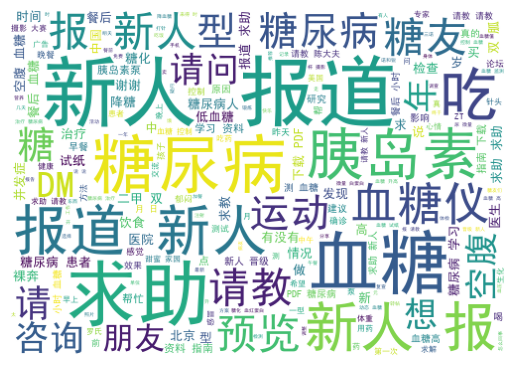

In [24]:
lda_model_train('./male_cut.txt',5)
word_cloud('./male_cut.txt')

0:
  "新人" (0.066)
  "报道" ( 0.042)
  "报" ( 0.038)
  "血糖仪" ( 0.028)
  "做"( 0.013)
1:
  "请教" (0.033)
  "吃" ( 0.029)
  "胰岛素" ( 0.026)
  "低血糖" ( 0.019)
  "预览"( 0.014)
2:
  "血糖" (0.081)
  "求助" ( 0.020)
  "空腹" ( 0.015)
  "吃" ( 0.013)
  "餐后"( 0.011)
3:
  "求助" (0.088)
  "糖" ( 0.029)
  "求" ( 0.012)
  "胰岛素" ( 0.011)
  "吃"( 0.009)
4:
  "糖尿病" (0.073)
  "型" ( 0.024)
  "请" ( 0.015)
  "治疗" ( 0.012)
  "运动"( 0.012)


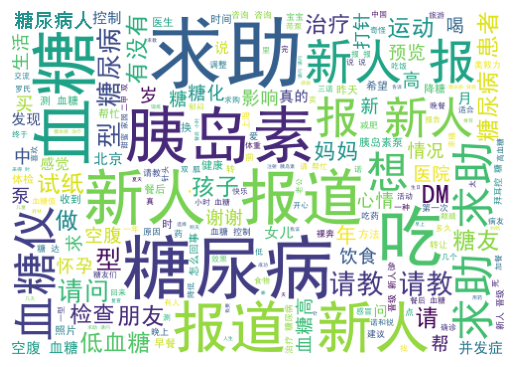

In [25]:
lda_model_train('./female_cut.txt',5)
word_cloud('./female_cut.txt')

# 4 情感分析

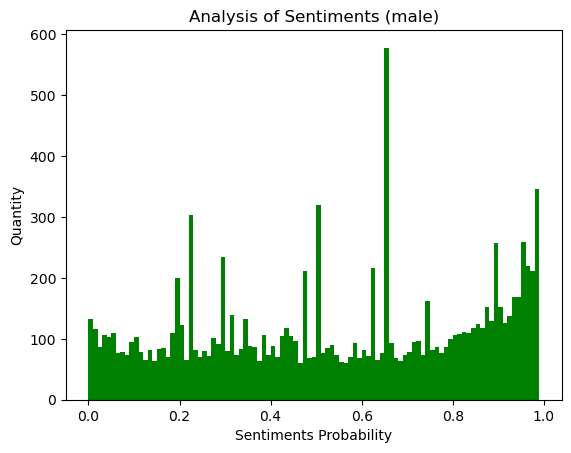

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from snownlp import SnowNLP
from snownlp import sentiment

#@ 对文件进行情感分析，并分别输出积极与消极的文件,同时绘制图
def sentiment_analyse(_input:str,_output_pos:str,_output_neg:str):
    """
    * _input : 需要进行情感分析的txt文件路径
    * _output_pos : 情感分析为积极的结果的输出路径
    * _output_neg : 情感分析为消极的结果的输出路径
    """

    sentiments_list = []
    pos = ['content']
    neg = ['content']
    pos_sentiment = ['sentiment']
    neg_sentiment = ['sentiment']
    inputs=open(_input,'r',encoding='utf-8')
    for line in inputs.readlines():
        sentiment=SnowNLP(line).sentiments
        sentiments_list.append(sentiment)
        if sentiment >= 0.6:
            pos.append(line)
            pos_sentiment.append(str(sentiment))
        if sentiment <= 0.4:
            neg.append(line)
            neg_sentiment.append(str(sentiment))

    df_pos=[pos,pos_sentiment]
    df_pos=pd.DataFrame(df_pos)
    df_pos=np.transpose(df_pos)
    df_pos.to_csv(_output_pos,index=False,header=False,encoding='utf-8')        # type: ignore

    df_neg=[neg,neg_sentiment]
    df_neg=pd.DataFrame(df_neg)
    df_neg=np.transpose(df_neg)
    df_neg.to_csv(_output_neg,index=False,header=False,encoding='utf-8')        # type: ignore

    #* 全部评论的情感分布情况
    plt.hist(sentiments_list, bins = np.arange(0, 1, 0.01), facecolor = 'g')
    plt.xlabel('Sentiments Probability')
    plt.ylabel('Quantity')
    title='Analysis of Sentiments'
    if('female' in _input):
        title+=' (female)'
    else:
        title+=' (male)'
    plt.title(title)
    plt.show()


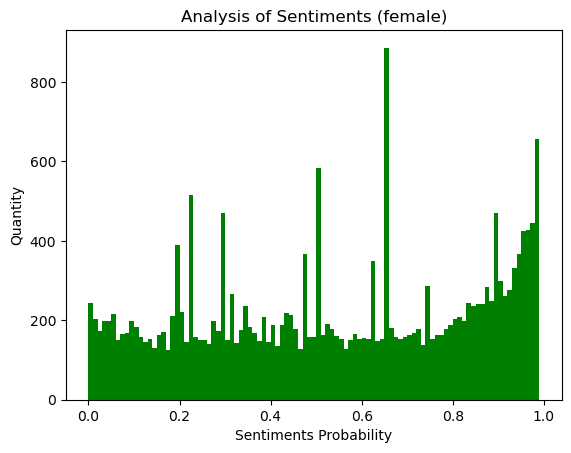

In [3]:
sentiment_analyse('./female_init.txt','./female_pos.txt','./female_neg.txt')